<a href="https://colab.research.google.com/github/Trading-com-Dados/desenvolvimento_interno/blob/main/006up_BACKTESTING_2_0_o_ceu_e_o_limite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **BACKTESTING 2.0: o céu é o limite!** 
---
#### *Disclaimer:*
#### Este código foi elaborado para fins exclusivamente educacionais. O conteúdo aqui apresentado visa fornecer informações complementares para auxiliar o investidor na tomada de suas próprias decisões de investimento. Reforçando, nenhum tópico aqui abordado constitui qualquer tipo de indicação/oferta/solicitação de compra/venda de qualquer produto.
---



# **Prefácio**

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="500">

TALVEZ COMENTAR Q É UM CÓDIGO SIMPLES MAS QUE EXIGIRÁ A CONSTRUÇÃO DE CADA OBJETO NECESSÁRIO, DIFERENTEMENTE DO BACKTRADER Q JA TEM TUDO PRONTO PRATICAMENTE (SE QUER AGILIDADE FICARA ENGESSADO). AO MESMO TEMPO, AQUI DARÁ MAIS LIBERDADE. IMAGINA TRANSFORMAR ISSO AQUI NUMA BIBLIOTECA DE BACKTESTING DA TRADING COM DADOS?

# **1. Bibliotecas utilizadas**

In [1]:
!pip install numpy pandas
!pip install matplotlib plotly
!pip install yfinance python-binance
!pip install ta
!pip install backtrader

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 12.2 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 1.1 MB 32.0 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 288 kB 58.9 MB/s 
     |████████████████████████████████| 103 kB 56.4 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 
     |████████████████████████████████| 271 kB 56.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import pytz as pytz
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
from plotly.subplots import make_subplots
import yfinance as yf
from binance.client import Client
import ta
import backtrader as bt
%matplotlib inline

# **2. Setup Preço de Fechamento de Reversão**

Setup Preço de fechamento de reversão:

Desenvolvida por Alexandre Wolwacz (Stormer do mercado)

Reversão de tendência e possui as seguintes regras de construção:
1) Quando a mínima do candle atual for menor do que a mínima dos dois últimos candles prévios e;
2) o fechamento do candle atual for maior do que o fechamento do candle anterior, 
tem-se o padrão de formação do setup. Como mostra a imagem abaixo.


<h1> Alterar por imagens nossas

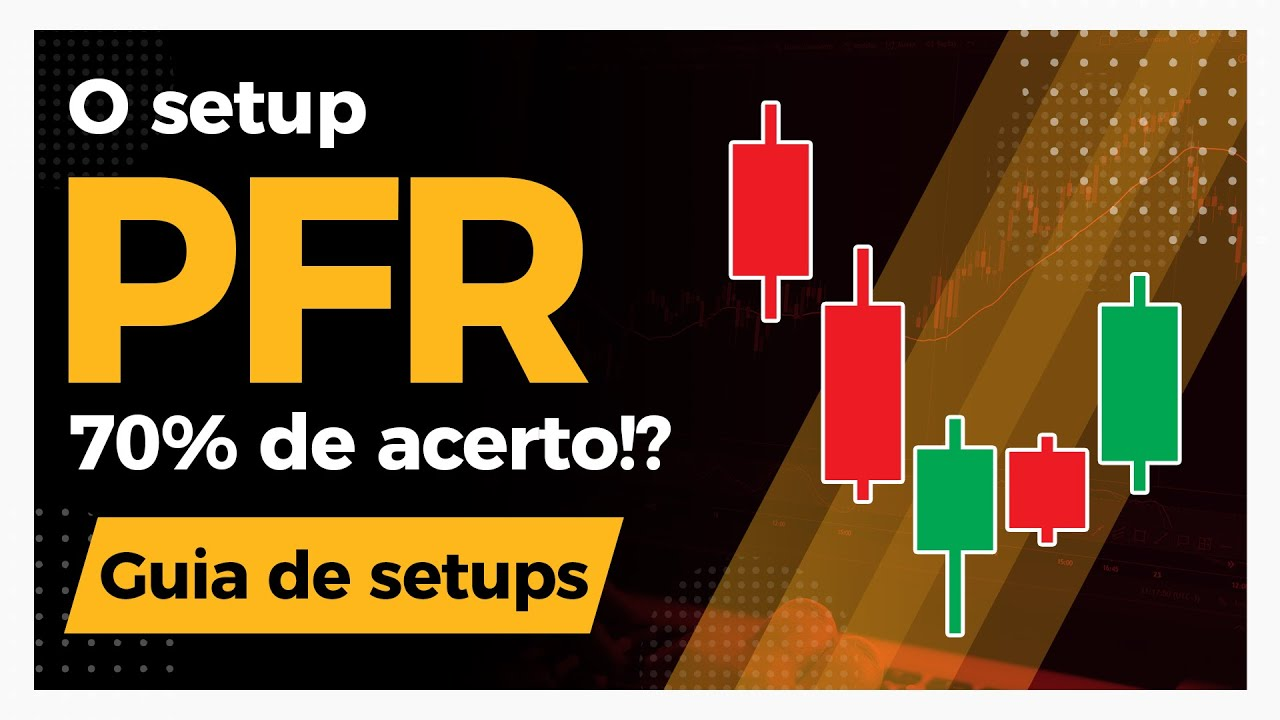

In [3]:
import IPython
url = 'https://i.ytimg.com/vi/BG-vo7BEPUU/maxresdefault.jpg'
IPython.display.Image(url, width = 300)

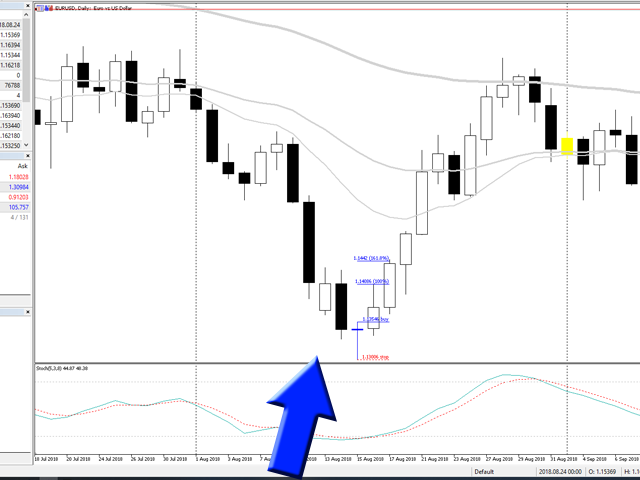

In [4]:
import IPython
url = 'https://c.mql5.com/31/497/setup-stormer-screen-6168.png'
IPython.display.Image(url, width = 600)

Quais as variaveis que precisarei:
* Regra 1: Low0 < (Low1 e Low2)
* Regra 2: Close > Close1

COISAS PRA AUMENTAR COMPLEXIDADE

* estabelecer ordens não a mercado (buylimit)
* determinar alvos gain e stop
* operar intradiario (encerrar no fim do dia depois de um horario)

* Calcular resumo de operaçoes num dataframe a parte, com PL, evolucao profit...
* definir spread para entrar tick+1


# **3. Backtesting Setup PFR em Bitcoin ao longo de 2021**

## **3.1. Importar cotações online Binance**

In [36]:
client = Client()
btcbrl = client.get_historical_klines(symbol='BTCBRL', start_str = '2021-01-01', end_str = '2021-12-31', interval=Client.KLINE_INTERVAL_1DAY)
btcbrl[0:3]

[[1609459200000,
  '152056.00000000',
  '154167.00000000',
  '150911.00000000',
  '153480.00000000',
  '58.94861700',
  1609545599999,
  '9013538.82790500',
  6193,
  '31.66333800',
  '4844372.87657400',
  '0'],
 [1609545600000,
  '153478.00000000',
  '173900.00000000',
  '152171.00000000',
  '168784.00000000',
  '187.81836700',
  1609631999999,
  '31072559.50919900',
  17243,
  '94.22368100',
  '15547826.49058000',
  '0'],
 [1609632000000,
  '168885.00000000',
  '180925.00000000',
  '167897.00000000',
  '173503.00000000',
  '172.84791800',
  1609718399999,
  '30309745.06470000',
  19212,
  '88.11589700',
  '15459361.59199600',
  '0']]

In [37]:
btc_df = pd.DataFrame(btcbrl)
btc_df.rename(columns={0:'date',1:'open',2:'high',3:'low',4:'close'},inplace=True)
btc_df.set_index('date', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index,unit='ms')
btc_df = btc_df.drop(btc_df.columns[4:],axis=1)
btc_df['open'] = pd.to_numeric(btc_df['open'])
btc_df['high'] = pd.to_numeric(btc_df['high'])
btc_df['low'] = pd.to_numeric(btc_df['low'])
btc_df['close'] = pd.to_numeric(btc_df['close'])
btc_df

,open,high,low,close
date,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0
2021-01-02,153478.0,173900.0,152171.0,168784.0
2021-01-03,168885.0,180925.0,167897.0,173503.0
2021-01-04,173504.0,175981.0,150000.0,169820.0
2021-01-05,169825.0,182966.0,159769.0,179972.0
...,...,...,...,...
2021-12-27,290189.0,295785.0,287534.0,288378.0
2021-12-28,288339.0,288339.0,269171.0,270226.0
2021-12-29,270357.0,274941.0,264773.0,266975.0


## **3.2. Definir parâmetros gerais da estratégia:**

Ajuda mt na hora de alterar alguma váriavel, trocar de ativos, dizer se é day trade ou nao...

In [38]:
## Variação mínima do preço || Ações = R$0.01 || WINFUT = 5pts || INDFUT= 1pt
## Alvos Fibonacci

tick_min = 1
Alvo_Fibonacci = 1.61

## **3.3. Sinais de entrada COMPRA e ordem Buy Limit**


**Regra 1:** Low 0 < (Low 1 e Low 2)

In [39]:
## Mínimas dos últimos candles
min_2cd_ant = btc_df['low'].rolling(window=2,closed='left').min()
btc_df['min_2cd_ant'] = min_2cd_ant
btc_df.head()

,open,high,low,close,min_2cd_ant
date,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0


In [40]:
Regra1 =  btc_df['low'] < btc_df['min_2cd_ant']
btc_df['Regra1'] = Regra1
btc_df.head(10)

,open,high,low,close,min_2cd_ant,Regra1
date,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False
2021-01-06,179990.0,197555.0,177210.0,196635.0,150000.0,False
2021-01-07,196752.0,222813.0,194600.0,215874.0,159769.0,False
2021-01-08,216160.0,228045.0,200150.0,222915.0,177210.0,False
2021-01-09,223113.0,225333.0,213593.0,220612.0,194600.0,False


In [41]:
fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-01-01',end='2021-01-04')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='<b>Regra 1 (low 0 < low 1,2) = True' ,width=1000 ,height=500)
fig.show()

**Regra 2:** Close 0 > Close 1

In [42]:
## Fechamento do candle anterior
fech_cd_ant = btc_df['close'].rolling(window=1,closed='left').min()
btc_df['fech_cd_ant'] = fech_cd_ant
btc_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant
date,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0


In [43]:
Regra2 =  btc_df['close'] > btc_df['fech_cd_ant']
btc_df['Regra2'] = Regra2
btc_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2
date,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True


In [44]:
fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-01-01',end='2021-01-04')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text=('<b>Regra 2 (close 0 > close 1) = False') ,width=1000 ,height=500)

fig.show()

In [45]:
## Se Regra 1 e 2 forem verdadeiras → sinal de compra = True
sinal_compra = btc_df['Regra1'] * btc_df['Regra2']
btc_df['sinal_compra'] = sinal_compra
btc_df.head(25)

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra
date,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False
2021-01-06,179990.0,197555.0,177210.0,196635.0,150000.0,False,179972.0,True,False
2021-01-07,196752.0,222813.0,194600.0,215874.0,159769.0,False,196635.0,True,False
2021-01-08,216160.0,228045.0,200150.0,222915.0,177210.0,False,215874.0,True,False
2021-01-09,223113.0,225333.0,213593.0,220612.0,194600.0,False,222915.0,False,False


In [46]:
## Filtro: apenas candles que representaram sinal de compra
sinal_compra_df = btc_df[btc_df.sinal_compra == True]
sinal_compra_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra
date,,,,,,,,,
2021-01-22,167340.0,186000.0,155000.0,181268.0,163651.0,True,167696.0,True,True
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True
2021-06-20,183146.0,186220.0,172850.0,183349.0,179346.0,True,183116.0,True,True
2021-06-22,160890.0,169364.0,145000.0,163318.0,159301.0,True,160917.0,True,True
2021-06-26,158466.0,163250.0,151151.0,161319.0,156801.0,True,158467.0,True,True


In [47]:
## Variavel interessante: Qts entradas considerando este ativo, neste intervalo e neste timeframe?
n_sinal_compra_df = len(sinal_compra_df)
n_sinal_compra_df

25

In [48]:
## Visualização usando um data range
data_range_btc_df = pd.date_range(start='2021-03-01',end='2021-03-31')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra
date,,,,,,,,,
2021-03-01,257538.0,282000.0,256447.0,281400.0,246517.0,False,257551.0,True,False
2021-03-02,281490.0,284121.0,269332.0,277000.0,246517.0,False,281400.0,False,False
2021-03-03,277000.0,299600.0,275353.0,285401.0,256447.0,False,277000.0,True,False
2021-03-04,285401.0,293100.0,271140.0,277237.0,269332.0,False,285401.0,False,False
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True
2021-03-06,279696.0,282000.0,271285.0,279999.0,266390.0,False,279491.0,True,False
2021-03-07,280000.0,291899.0,279950.0,288621.0,266390.0,False,279999.0,True,False
2021-03-08,289458.0,303500.0,280970.0,303500.0,271285.0,False,288621.0,True,False
2021-03-09,303500.0,319500.0,300665.0,318596.0,279950.0,False,303500.0,True,False


In [49]:
## Geral 
fig = make_subplots(rows=1, cols=2)

## Figura 1
data_range_btc_df = pd.date_range(start='2021-03-01',end='2021-03-31')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close']), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)",row=1, col=1)
fig.add_vrect(x0='2021-03-02 12:00', x1='2021-03-07 15:00', fillcolor="green", opacity=0.25, line_width=0,row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-03-05'],y=[330000],mode="text",text="<b>Zoom",textposition="top center",showlegend=False),row=1, col=1)

## Figura 2
data_range_btc_df = pd.date_range(start='2021-03-03',end='2021-03-07')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=False), row=1,col=2)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=2)
fig.add_annotation(x='2021-03-05',y=270000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_trace(go.Scatter(x=['2021-03-04 20:00','2021-03-07 10:00'],y=[283451,283451,283451], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=2)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,xaxis2_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra PFR' ,width=1000 ,height=500)

fig.show()

In [50]:
## Figura 2 apenas
fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-03-03',end='2021-03-07')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)
fig.add_annotation(x='2021-03-05',y=270000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-03-04 20:00','2021-03-07 10:00'],y=[283451,283451,283451], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra PFR' ,width=1000 ,height=500)

fig.show()

In [51]:
## O que aconteceu depois?

fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-03-03',end='2021-03-12')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)
fig.add_annotation(x='2021-03-05',y=270000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-03-04 20:00','2021-03-07 10:00'],y=[283451,283451,283451], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra PFR' ,width=1000 ,height=500)

fig.show()

## **3.3. Entradas de COMPRA executadas**

Se Preco > High (candle sinalizador) + Min_Incr = Compra executada<p>
PS: Definiremos que o período máx para acontecer são 2 candles

In [52]:
## Criar uma coluna para informar se entrei ou nao na operação. Daremos uma janela de 2 candles no máx para entrar.
## Para células posteriores, usar o FixedForwardWindowIndexer

## Máximas dos próximos 2 candles
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
max_cd_sig_prox = btc_df['high'].rolling(window=indexer).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
max_cd_sig_prox2 = btc_df['high'].rolling(window=indexer).max()
btc_df['max_cd_sig_prox'] = max_cd_sig_prox
btc_df['max_cd_sig_prox2'] = max_cd_sig_prox2
btc_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2
date,,,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False,173900.0,180925.0
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False,180925.0,180925.0
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False,180925.0,182966.0
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False,182966.0,197555.0
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False,197555.0,222813.0


In [53]:
## Entrada compra ativada? Lembrando que tick_min foi definido em params
btc_df['Compra_ativ_1cd'] = (btc_df['max_cd_sig_prox'] > (btc_df['high']+1*tick_min)) *  btc_df['sinal_compra']
btc_df['Compra_ativ_2cd'] = (btc_df['max_cd_sig_prox2'] > (btc_df['high']+1*tick_min)) *  btc_df['sinal_compra']
btc_df.head(25)

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd
date,,,,,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False,173900.0,180925.0,False,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False,180925.0,180925.0,False,False
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False,180925.0,182966.0,False,False
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False,182966.0,197555.0,False,False
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False,197555.0,222813.0,False,False
2021-01-06,179990.0,197555.0,177210.0,196635.0,150000.0,False,179972.0,True,False,222813.0,228045.0,False,False
2021-01-07,196752.0,222813.0,194600.0,215874.0,159769.0,False,196635.0,True,False,228045.0,228045.0,False,False
2021-01-08,216160.0,228045.0,200150.0,222915.0,177210.0,False,215874.0,True,False,228045.0,228045.0,False,False
2021-01-09,223113.0,225333.0,213593.0,220612.0,194600.0,False,222915.0,False,False,225333.0,225333.0,False,False


In [54]:
data_range_btc_df = pd.date_range(start='2021-01-19',end='2021-01-24')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.add_annotation(x='2021-01-22',y=160000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=16,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_annotation(x='2021-01-22',y=186001, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=16,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_trace(go.Scatter(x=['2021-01-21 20:00','2021-01-24 10:00'],y=[186001,186001,186001], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

fig.add_annotation(x='2021-01-24',y=186001, xref="x",yref="y",text="<b>Compra NÃO ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, title_text='Sinal Compra PFR',width=800 ,height=800)
fig.show()

In [55]:
data_range_btc_df = pd.date_range(start='2021-01-19',end='2021-01-31')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.add_annotation(x='2021-01-22',y=160000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_annotation(x='2021-01-22',y=186001, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_trace(go.Scatter(x=['2021-01-21 20:00','2021-01-24 10:00'],y=[186001,186001,186001], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

fig.add_annotation(x='2021-01-24',y=186001, xref="x",yref="y",text="<b>Compra NÃO ativada",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, title_text='Sinal Compra PFR',width=800 ,height=800)
fig.show()

In [56]:
## Filtro: apenas candles que representaram sinal de compra (apresentado acima mas agora com entrada ativada)
sinal_compra_df = btc_df[btc_df.sinal_compra == True]
sinal_compra_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd
date,,,,,,,,,,,,,
2021-01-22,167340.0,186000.0,155000.0,181268.0,163651.0,True,167696.0,True,True,186000.0,186000.0,False,False
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True,283451.0,291899.0,False,True
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True,331244.0,335000.0,True,True
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True,318778.0,318778.0,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True,339093.0,339654.0,True,True
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True,196776.0,198465.0,True,True
2021-06-20,183146.0,186220.0,172850.0,183349.0,179346.0,True,183116.0,True,True,186220.0,186220.0,False,False
2021-06-22,160890.0,169364.0,145000.0,163318.0,159301.0,True,160917.0,True,True,177000.0,177000.0,True,True
2021-06-26,158466.0,163250.0,151151.0,161319.0,156801.0,True,158467.0,True,True,172443.0,174804.0,True,True


In [57]:
## Filtro: apenas candles que representaram sinal de compra (apresentado acima mas agora com entrada ativada)
compras_ativadas_1cd_df = sinal_compra_df[sinal_compra_df.Compra_ativ_1cd == True]
compras_ativadas_2cd_df = sinal_compra_df[sinal_compra_df.Compra_ativ_2cd == True]
print(len(compras_ativadas_1cd_df))
len(compras_ativadas_2cd_df)

20


23

## **3.4. Definindo os alvos gain x stop loss**

candle sinalizador = cdsig<p>
Alvo_Fibonacci = 1.61

*Stop loss*:<p>
Preco < Low_cdsig - Min_Incr -> Sell to Cover Stop<p>

*Alvos Gain* (2):<p>
Gain1 = Se Preco > (Max_cdsig + Min_Incr) + Amplitude_cdsig = Sell to Cover Limit<p>
Gain2 = Se Preco > (Max_cdsig + Min_Incr) + (Amplitude_cdsig * 1.61) = Sell to Cover Limit

In [59]:
## Amplitude (max - min) do candle sinalizador
btc_df['range'] = btc_df['high']-btc_df['low']

## Preço do Stop loss: Min cd sinal - tick_min

btc_df['stop_loss'] = btc_df['low'] - tick_min

## Preco Alvo Gain: Max cd sinal + 1 + Range candle sinal

btc_df['alvo_gain1'] = btc_df['high'] + tick_min + btc_df['range']
btc_df['alvo_gain2'] = btc_df['high'] + tick_min + (Alvo_Fibonacci * btc_df['range'])

btc_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd,range,stop_loss,alvo_gain1,alvo_gain2
date,,,,,,,,,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False,173900.0,180925.0,False,False,3256.0,150910.0,157424.0,159410.16
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False,180925.0,180925.0,False,False,21729.0,152170.0,195630.0,208884.69
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False,180925.0,182966.0,False,False,13028.0,167896.0,193954.0,201901.08
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False,182966.0,197555.0,False,False,25981.0,149999.0,201963.0,217811.41
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False,197555.0,222813.0,False,False,23197.0,159768.0,206164.0,220314.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,290189.0,295785.0,287534.0,288378.0,283013.0,False,290188.0,False,False,295785.0,295785.0,False,False,8251.0,287533.0,304037.0,309070.11
2021-12-28,288339.0,288339.0,269171.0,270226.0,283013.0,True,288378.0,False,False,288339.0,288339.0,False,False,19168.0,269170.0,307508.0,319200.48
2021-12-29,270357.0,274941.0,264773.0,266975.0,269171.0,True,270226.0,False,False,280000.0,280000.0,False,False,10168.0,264772.0,285110.0,291312.48


## **3.5. Verificar onde o preço chegou primeiro: stop loss ou gain?**

In [60]:
## Primeiro devo calcular a min e max dos 'próximos candles' (lembrando que inclui o candle sinalizador)
## Entretanto, dependendo do tempo da operação pode ficar chato fazer na mão (além de grande risco de erros)

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
min_cd_prox1 = btc_df['low'].rolling(window=indexer).min()
max_cd_prox1 = btc_df['high'].rolling(window=indexer).max()

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
min_cd_prox2 = btc_df['low'].rolling(window=indexer).min()
max_cd_prox2 = btc_df['high'].rolling(window=indexer).max()

<img src="https://s3.manualzz.com/store/data/035682191_1-cb12413719b59b4f0190c1355bbe02ad-360x466.png" width="300">


In [61]:
## Aqui você pode determinar até quantos candles ficará na operação. Aqui depende mt do setup. Alguns encerram por tempo, outros so qd chegar nos alvos...
## Copiar o outputr e colar na linha de código abaixo

for i in range(1,11):
  print('indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=',i+1,')',sep='')
  print('btc_df["min_cd_prox',i,'"] = btc_df["low"].rolling(window=',i+1,').min()',sep='')
  print('btc_df["max_cd_prox',i,'"] = btc_df["high"].rolling(window=',i+1,').max()',sep='')

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
btc_df["min_cd_prox1"] = btc_df["low"].rolling(window=2).min()
btc_df["max_cd_prox1"] = btc_df["high"].rolling(window=2).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
btc_df["min_cd_prox2"] = btc_df["low"].rolling(window=3).min()
btc_df["max_cd_prox2"] = btc_df["high"].rolling(window=3).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)
btc_df["min_cd_prox3"] = btc_df["low"].rolling(window=4).min()
btc_df["max_cd_prox3"] = btc_df["high"].rolling(window=4).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
btc_df["min_cd_prox4"] = btc_df["low"].rolling(window=5).min()
btc_df["max_cd_prox4"] = btc_df["high"].rolling(window=5).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)
btc_df["min_cd_prox5"] = btc_df["low"].rolling(window=6).min()
btc_df["max_cd_prox5"] = btc_df["high"].rolling(window=6).max()
indexer = pd.api.indexers.Fixe

In [62]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
btc_df["min_cd_prox1"] = btc_df["low"].rolling(window=2).min()
btc_df["max_cd_prox1"] = btc_df["high"].rolling(window=2).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
btc_df["min_cd_prox2"] = btc_df["low"].rolling(window=3).min()
btc_df["max_cd_prox2"] = btc_df["high"].rolling(window=3).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)
btc_df["min_cd_prox3"] = btc_df["low"].rolling(window=4).min()
btc_df["max_cd_prox3"] = btc_df["high"].rolling(window=4).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
btc_df["min_cd_prox4"] = btc_df["low"].rolling(window=5).min()
btc_df["max_cd_prox4"] = btc_df["high"].rolling(window=5).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)
btc_df["min_cd_prox5"] = btc_df["low"].rolling(window=6).min()
btc_df["max_cd_prox5"] = btc_df["high"].rolling(window=6).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=7)
btc_df["min_cd_prox6"] = btc_df["low"].rolling(window=7).min()
btc_df["max_cd_prox6"] = btc_df["high"].rolling(window=7).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=8)
btc_df["min_cd_prox7"] = btc_df["low"].rolling(window=8).min()
btc_df["max_cd_prox7"] = btc_df["high"].rolling(window=8).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=9)
btc_df["min_cd_prox8"] = btc_df["low"].rolling(window=9).min()
btc_df["max_cd_prox8"] = btc_df["high"].rolling(window=9).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=10)
btc_df["min_cd_prox9"] = btc_df["low"].rolling(window=10).min()
btc_df["max_cd_prox9"] = btc_df["high"].rolling(window=10).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=11)
btc_df["min_cd_prox10"] = btc_df["low"].rolling(window=11).min()
btc_df["max_cd_prox10"] = btc_df["high"].rolling(window=11).max()

In [70]:
print(len(btc_df.columns))
btc_df.columns

37


Index(['open', 'high', 'low', 'close', 'min_2cd_ant', 'Regra1', 'fech_cd_ant',
       'Regra2', 'sinal_compra', 'max_cd_sig_prox', 'max_cd_sig_prox2',
       'Compra_ativ_1cd', 'Compra_ativ_2cd', 'range', 'stop_loss',
       'alvo_gain1', 'alvo_gain2', 'min_cd_prox1', 'max_cd_prox1',
       'min_cd_prox2', 'max_cd_prox2', 'min_cd_prox3', 'max_cd_prox3',
       'min_cd_prox4', 'max_cd_prox4', 'min_cd_prox5', 'max_cd_prox5',
       'min_cd_prox6', 'max_cd_prox6', 'min_cd_prox7', 'max_cd_prox7',
       'min_cd_prox8', 'max_cd_prox8', 'min_cd_prox9', 'max_cd_prox9',
       'min_cd_prox10', 'max_cd_prox10'],
      dtype='object')

In [76]:
print(btc_df.columns.get_loc("stop_loss"))
print(btc_df.columns.get_loc("alvo_gain1"))
print(btc_df.columns.get_loc("alvo_gain2"))
print(btc_df.columns.get_loc("min_cd_prox1"))
print(btc_df.columns.get_loc("max_cd_prox1"))
print(btc_df.columns.get_loc("min_cd_prox10"))
print(btc_df.columns.get_loc("max_cd_prox10"))

14
15
16
17
18
35
36


In [78]:
btc_df[btc_df.columns[12]]

date
2021-01-01    False
2021-01-02    False
2021-01-03    False
2021-01-04    False
2021-01-05    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: Compra_ativ_2cd, Length: 365, dtype: bool

Muitas formas potenciais de calcular: pivot table, if, while, rolling (axis =1)...<p>
Vamos usar esse mais simples como feito no anterior

In [81]:
for i in range(1,11):
  print('btc_df["Loss_',i,'"] = btc_df["min_cd_prox',i,'"] < btc_df["stop_loss"]',sep='')
  print('btc_df["Gain1_',i,'"] = btc_df["max_cd_prox',i,'"] > btc_df["alvo_gain1"]',sep='')
  print('btc_df["Gain2_',i,'"] = btc_df["max_cd_prox',i,'"] > btc_df["alvo_gain2"]',sep='')

btc_df["Loss_1"] = btc_df["min_cd_prox1"] < btc_df["stop_loss"]
btc_df["Gain1_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain1"]
btc_df["Gain2_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain2"]
btc_df["Loss_2"] = btc_df["min_cd_prox2"] < btc_df["stop_loss"]
btc_df["Gain1_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain1"]
btc_df["Gain2_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain2"]
btc_df["Loss_3"] = btc_df["min_cd_prox3"] < btc_df["stop_loss"]
btc_df["Gain1_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain1"]
btc_df["Gain2_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain2"]
btc_df["Loss_4"] = btc_df["min_cd_prox4"] < btc_df["stop_loss"]
btc_df["Gain1_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain1"]
btc_df["Gain2_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain2"]
btc_df["Loss_5"] = btc_df["min_cd_prox5"] < btc_df["stop_loss"]
btc_df["Gain1_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain1"]
btc_df["Gain2_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain2"]
btc_df["Loss_6"] = b

In [82]:
btc_df["Loss_1"] = btc_df["min_cd_prox1"] < btc_df["stop_loss"]
btc_df["Gain1_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain1"]
btc_df["Gain2_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain2"]
btc_df["Loss_2"] = btc_df["min_cd_prox2"] < btc_df["stop_loss"]
btc_df["Gain1_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain1"]
btc_df["Gain2_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain2"]
btc_df["Loss_3"] = btc_df["min_cd_prox3"] < btc_df["stop_loss"]
btc_df["Gain1_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain1"]
btc_df["Gain2_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain2"]
btc_df["Loss_4"] = btc_df["min_cd_prox4"] < btc_df["stop_loss"]
btc_df["Gain1_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain1"]
btc_df["Gain2_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain2"]
btc_df["Loss_5"] = btc_df["min_cd_prox5"] < btc_df["stop_loss"]
btc_df["Gain1_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain1"]
btc_df["Gain2_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain2"]
btc_df["Loss_6"] = btc_df["min_cd_prox6"] < btc_df["stop_loss"]
btc_df["Gain1_6"] = btc_df["max_cd_prox6"] > btc_df["alvo_gain1"]
btc_df["Gain2_6"] = btc_df["max_cd_prox6"] > btc_df["alvo_gain2"]
btc_df["Loss_7"] = btc_df["min_cd_prox7"] < btc_df["stop_loss"]
btc_df["Gain1_7"] = btc_df["max_cd_prox7"] > btc_df["alvo_gain1"]
btc_df["Gain2_7"] = btc_df["max_cd_prox7"] > btc_df["alvo_gain2"]
btc_df["Loss_8"] = btc_df["min_cd_prox8"] < btc_df["stop_loss"]
btc_df["Gain1_8"] = btc_df["max_cd_prox8"] > btc_df["alvo_gain1"]
btc_df["Gain2_8"] = btc_df["max_cd_prox8"] > btc_df["alvo_gain2"]
btc_df["Loss_9"] = btc_df["min_cd_prox9"] < btc_df["stop_loss"]
btc_df["Gain1_9"] = btc_df["max_cd_prox9"] > btc_df["alvo_gain1"]
btc_df["Gain2_9"] = btc_df["max_cd_prox9"] > btc_df["alvo_gain2"]
btc_df["Loss_10"] = btc_df["min_cd_prox10"] < btc_df["stop_loss"]
btc_df["Gain1_10"] = btc_df["max_cd_prox10"] > btc_df["alvo_gain1"]
btc_df["Gain2_10"] = btc_df["max_cd_prox10"] > btc_df["alvo_gain2"]

In [86]:
## Filtrar apenas os com entrada de compra ativada
compras_ativadas_1cd_df = btc_df[btc_df.Compra_ativ_1cd == True]
compras_ativadas_2cd_df = btc_df[btc_df.Compra_ativ_2cd == True]
compras_ativadas_2cd_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd,range,stop_loss,alvo_gain1,alvo_gain2,min_cd_prox1,max_cd_prox1,min_cd_prox2,max_cd_prox2,min_cd_prox3,max_cd_prox3,min_cd_prox4,max_cd_prox4,min_cd_prox5,max_cd_prox5,min_cd_prox6,max_cd_prox6,min_cd_prox7,max_cd_prox7,min_cd_prox8,max_cd_prox8,min_cd_prox9,max_cd_prox9,min_cd_prox10,max_cd_prox10,Loss_1,Gain1_1,Gain2_1,Loss_2,Gain1_2,Gain2_2,Loss_3,Gain1_3,Gain2_3,Loss_4,Gain1_4,Gain2_4,Loss_5,Gain1_5,Gain2_5,Loss_6,Gain1_6,Gain2_6,Loss_7,Gain1_7,Gain2_7,Loss_8,Gain1_8,Gain2_8,Loss_9,Gain1_9,Gain2_9,Loss_10,Gain1_10,Gain2_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True,283451.0,291899.0,False,True,17061.0,266389.0,300513.0,310920.21,266390.0,293100.0,266390.0,299600.0,266390.0,299600.0,256447.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,302000.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True,331244.0,335000.0,True,True,17174.0,305261.0,339611.0,350087.14,305262.0,344150.0,305262.0,345300.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,300665.0,346263.0,280970.0,346263.0,279950.0,346263.0,271285.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,True,True,False,True,True,False,True,True,False
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True,318778.0,318778.0,True,True,13748.0,296251.0,323749.0,332135.28,296252.0,325549.0,296252.0,326996.0,296252.0,331000.0,296252.0,331000.0,296252.0,335000.0,296252.0,335000.0,296252.0,335000.0,296252.0,344150.0,296252.0,345300.0,296252.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True,339093.0,339654.0,True,True,10502.0,328094.0,349100.0,355506.22,328095.0,342116.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,316296.0,344298.0,316009.0,344298.0,312901.0,344298.0,293200.0,344298.0,288502.0,344298.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True,196776.0,198465.0,True,True,15400.0,176726.0,207528.0,216922.00,176727.0,196773.0,176727.0,205598.0,176727.0,215500.0,176727.0,217617.0,176727.0,217617.0,176727.0,217617.0,173177.0,217617.0,173177.0,217617.0,173177.0,226213.0,173177.0,231400.0,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2021-06-22,160890.0,169364.0,145000.0,163318.0,159301.0,True,160917.0,True,True,177000.0,177000.0,True,True,24364.0,144999.0,193729.0,208591.04,145000.0,184000.0,145000.0,186220.0,145000.0,187461.0,145000.0,193197.0,145000.0,201595.0,145000.0,205794.0,145000.0,209898.0,145000.0,210000.0,145000.0,210000.0,145000.0,210000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True
2021-06-26,158466.0,163250.0,151151.0,161319.0,156801.0,True,158467.0,True,True,172443.0,174804.0,True,True,12099.0,151150.0,175350.0,182730.39,151151.0,175799.0,151151.0,175799.0,151151.0,177000.0,145000.0,177000.0,145000.0,184000.0,145000.0,186220.0,145000.0,187461.0,145000.0,193197.0,145000.0,201595.0

In [97]:
compras_ativadas_2cd_df.columns

Index(['open', 'high', 'low', 'close', 'min_2cd_ant', 'Regra1', 'fech_cd_ant',
       'Regra2', 'sinal_compra', 'max_cd_sig_prox', 'max_cd_sig_prox2',
       'Compra_ativ_1cd', 'Compra_ativ_2cd', 'range', 'stop_loss',
       'alvo_gain1', 'alvo_gain2', 'min_cd_prox1', 'max_cd_prox1',
       'min_cd_prox2', 'max_cd_prox2', 'min_cd_prox3', 'max_cd_prox3',
       'min_cd_prox4', 'max_cd_prox4', 'min_cd_prox5', 'max_cd_prox5',
       'min_cd_prox6', 'max_cd_prox6', 'min_cd_prox7', 'max_cd_prox7',
       'min_cd_prox8', 'max_cd_prox8', 'min_cd_prox9', 'max_cd_prox9',
       'min_cd_prox10', 'max_cd_prox10', 'Loss_1', 'Gain1_1', 'Gain2_1',
       'Loss_2', 'Gain1_2', 'Gain2_2', 'Loss_3', 'Gain1_3', 'Gain2_3',
       'Loss_4', 'Gain1_4', 'Gain2_4', 'Loss_5', 'Gain1_5', 'Gain2_5',
       'Loss_6', 'Gain1_6', 'Gain2_6', 'Loss_7', 'Gain1_7', 'Gain2_7',
       'Loss_8', 'Gain1_8', 'Gain2_8', 'Loss_9', 'Gain1_9', 'Gain2_9',
       'Loss_10', 'Gain1_10', 'Gain2_10'],
      dtype='object')

In [98]:
print(compras_ativadas_2cd_df.columns.get_loc("Loss_1"))
print(compras_ativadas_2cd_df.columns.get_loc("Gain2_10"))

37
66


In [96]:
## Mt complexo ainda
compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns[37:67]]

,Loss_1,Gain1_1,Gain2_1,Loss_2,Gain1_2,Gain2_2,Loss_3,Gain1_3,Gain2_3,Loss_4,Gain1_4,Gain2_4,Loss_5,Gain1_5,Gain2_5,Loss_6,Gain1_6,Gain2_6,Loss_7,Gain1_7,Gain2_7,Loss_8,Gain1_8,Gain2_8,Loss_9,Gain1_9,Gain2_9,Loss_10,Gain1_10,Gain2_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False
2021-03-16,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,True,True,False,True,True,False,True,True,False
2021-03-23,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True
2021-04-04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-05-30,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2021-06-22,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True
2021-06-26,False,True,False,False,True,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2021-07-30,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-08-04,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False


In [100]:
compras_ativadas_2cd_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd,range,stop_loss,alvo_gain1,alvo_gain2,min_cd_prox1,max_cd_prox1,min_cd_prox2,max_cd_prox2,min_cd_prox3,max_cd_prox3,min_cd_prox4,max_cd_prox4,min_cd_prox5,max_cd_prox5,min_cd_prox6,max_cd_prox6,min_cd_prox7,max_cd_prox7,min_cd_prox8,max_cd_prox8,min_cd_prox9,max_cd_prox9,min_cd_prox10,max_cd_prox10,Loss_1,Gain1_1,Gain2_1,Loss_2,Gain1_2,Gain2_2,Loss_3,Gain1_3,Gain2_3,Loss_4,Gain1_4,Gain2_4,Loss_5,Gain1_5,Gain2_5,Loss_6,Gain1_6,Gain2_6,Loss_7,Gain1_7,Gain2_7,Loss_8,Gain1_8,Gain2_8,Loss_9,Gain1_9,Gain2_9,Loss_10,Gain1_10,Gain2_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True,283451.0,291899.0,False,True,17061.0,266389.0,300513.0,310920.21,266390.0,293100.0,266390.0,299600.0,266390.0,299600.0,256447.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,302000.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True,331244.0,335000.0,True,True,17174.0,305261.0,339611.0,350087.14,305262.0,344150.0,305262.0,345300.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,300665.0,346263.0,280970.0,346263.0,279950.0,346263.0,271285.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,True,True,False,True,True,False,True,True,False
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True,318778.0,318778.0,True,True,13748.0,296251.0,323749.0,332135.28,296252.0,325549.0,296252.0,326996.0,296252.0,331000.0,296252.0,331000.0,296252.0,335000.0,296252.0,335000.0,296252.0,335000.0,296252.0,344150.0,296252.0,345300.0,296252.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True,339093.0,339654.0,True,True,10502.0,328094.0,349100.0,355506.22,328095.0,342116.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,316296.0,344298.0,316009.0,344298.0,312901.0,344298.0,293200.0,344298.0,288502.0,344298.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True,196776.0,198465.0,True,True,15400.0,176726.0,207528.0,216922.00,176727.0,196773.0,176727.0,205598.0,176727.0,215500.0,176727.0,217617.0,176727.0,217617.0,176727.0,217617.0,173177.0,217617.0,173177.0,217617.0,173177.0,226213.0,173177.0,231400.0,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [161]:
data_range_btc_df = pd.date_range(start='2021-03-01',end='2021-03-10')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.add_annotation(x='2021-03-05',y=275000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-07 10:00'],y=[283452,283452,283452], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='purple', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-07 10:00'],y=[266390,266390,266390], mode="lines+text", name="Stop Loss",
                         line = dict(color='red', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-05',y=266390, xref="x",yref="y",text="<b>Stop Loss",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

## Alvos Gain

fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-10 10:00'],y=[300513,300513,300513], mode="lines+text", name="Alvo Gain (Range)",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-05',y=300513, xref="x",yref="y",text="<b>Alvo Gain (Range)",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-10 10:00'],y=[310920,310920,310920], mode="lines+text", name="Alvo Gain (Fibo)",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-05',y=310920, xref="x",yref="y",text="<b>Alvo Gain (Fibo)",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, title_text='Sinal Compra PFR',width=1000 ,height=700)
fig.show()

In [103]:
compras_ativadas_2cd_df_long = pd.melt(compras_ativadas_2cd_df,ignore_index=False)
compras_ativadas_2cd_df_long

,variable,value
date,,
2021-03-05,open,277237.0
2021-03-16,open,317383.0
2021-03-23,open,303155.0
2021-04-04,open,332809.0
2021-05-30,open,182731.0
...,...,...
2021-11-19,Gain2_10,True
2021-11-23,Gain2_10,True
2021-12-11,Gain2_10,True


In [130]:
Loss01 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.variable == 'Loss_1') & (compras_ativadas_2cd_df_long.value == True)]
Loss01

,variable,value
date,,


In [133]:
Gain1_1 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.variable == 'Gain1_1') & (compras_ativadas_2cd_df_long.value == True)]
Gain1_1

,variable,value
date,,
2021-03-16,Gain1_1,True
2021-03-23,Gain1_1,True
2021-06-26,Gain1_1,True
2021-08-25,Gain1_1,True
2021-10-23,Gain1_1,True


In [134]:
Gain2_1 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.variable == 'Gain2_1') & (compras_ativadas_2cd_df_long.value == True)]
Gain2_1

,variable,value
date,,


In [136]:
 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.value == True] & compras_ativadas_2cd_df.columns.get_loc()
print(compras_ativadas_2cd_df.columns.get_loc("Loss_1"))

,variable,value
date,,
2021-03-05,Loss_10,True
2021-03-16,Loss_10,True
2021-04-04,Loss_10,True
2021-05-30,Loss_10,True
2021-06-26,Loss_10,True
2021-07-30,Loss_10,True
2021-08-04,Loss_10,True
2021-08-05,Loss_10,True
2021-08-18,Loss_10,True


In [119]:
compras_ativadas_2cd_df['Detector'] = (1==1)
compras_ativadas_2cd_df['Detector']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date
2021-03-05    True
2021-03-16    True
2021-03-23    True
2021-04-04    True
2021-05-30    True
2021-06-22    True
2021-06-26    True
2021-07-30    True
2021-08-04    True
2021-08-05    True
2021-08-18    True
2021-08-25    True
2021-09-01    True
2021-09-29    True
2021-10-23    True
2021-10-28    True
2021-11-06    True
2021-11-17    True
2021-11-19    True
2021-11-23    True
2021-12-11    True
2021-12-18    True
2021-12-26    True
Name: Detector, dtype: bool

In [125]:
lista_resultados = []

preco_atingiu = 'nada'

for i in range(37,len(compras_ativadas_2cd_df.columns)):
  if compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns[i]] == compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns['Detector']]:
    preco_atingiu = compras_ativadas_2cd_df.columns[i]
    lista_resultados.append()
  else:
    pass

IndexError: ignored

In [122]:
compras_ativadas_2cd_df.columns[37]

'Loss_1'

In [126]:
compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns[37]] 

date
2021-03-05    False
2021-03-16    False
2021-03-23    False
2021-04-04    False
2021-05-30    False
2021-06-22    False
2021-06-26    False
2021-07-30    False
2021-08-04    False
2021-08-05    False
2021-08-18    False
2021-08-25    False
2021-09-01    False
2021-09-29    False
2021-10-23    False
2021-10-28    False
2021-11-06    False
2021-11-17    False
2021-11-19    False
2021-11-23    False
2021-12-11    False
2021-12-18    False
2021-12-26    False
Name: Loss_1, dtype: bool